In [1]:
from map_generator import MapGenerator
from qlearning.qlearning import QLearningPathPlanner
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
from Planners.abc.abc_problem import ABCProblem
from Planners.pso.pso_problem import PSOProblem
from Planners.gwo.gwo_problem import GWOProblem
#from Planners.a_star.a_star import AStarPlanner
from map_resize.map_resize import get_resized_map, get_core_points, points_to_particle
from Planners.util.planner_base import PlannerBase
from Planners.helper import linear_interpolation, get_com_points
from IPython.display import display, clear_output

In [2]:
class AStarPlanner:
    class Node:
        def __init__(self, x_pos, y_pos, goal_node):
            self.x_pos, self.y_pos = x_pos, y_pos
            if goal_node is None:
                goal_node = self
            self.goal_node = goal_node
            self.parent = None
            self.distance = 0
            goal_distance = (x_pos - goal_node.x_pos) ** 2
            goal_distance += (y_pos - goal_node.y_pos) ** 2
            goal_distance = goal_distance ** 0.5
            self.goal_distance = goal_distance
            self.cost = goal_distance
        
        def set_parent(self, parent):
            self.parent = parent
            if self.x_pos == parent.x_pos or self.y_pos == parent.y_pos:
                step_length = 1
            else:
                step_length = 2 ** 0.5
            self.distance = parent.distance + step_length
            self.cost = self.distance + self.goal_distance
        
        def is_goal(self):
            return self.x_pos == self.goal_node.x_pos and self.y_pos == self.goal_node.y_pos

    def __init__(self, curr_map):
        self.map = curr_map
        self.y_min, self.x_min = 0, 0
        self.y_max, self.x_max = curr_map.shape
        self.visited = np.zeros(curr_map.shape, dtype=bool)
    
    def verifyNode(self, node):
        if node.x_pos < self.x_min:
            return False
        if node.x_pos >= self.x_max:
            return False
        if node.y_pos < self.y_min:
            return False
        if node.y_pos >= self.y_max:
            return False
        if self.map[node.y_pos, node.x_pos] == 0:
            return False
        return True
    
    def get_id(self, node):
        return node.y_pos * self.x_max + node.x_pos
    
    def get_neighbours(self, curr_node, goal_node):
        neighbour_nodes = list()
        for x_move in [-1, 0, 1]:
            for y_move in [-1, 0, 1]:
                if x_move == 0 and y_move == 0:
                    continue
                new_node = self.Node(curr_node.x_pos+x_move, curr_node.y_pos+y_move, goal_node)
                new_node.set_parent(curr_node)
                if self.verifyNode(new_node):
                    neighbour_nodes.append(new_node)
        return neighbour_nodes
    
    def get_path(self, start, end):
        goal_node = self.Node(end[0], end[1], None)
        start_node = self.Node(start[0], start[1], goal_node)
        goal_found = False
        
        if not self.verifyNode(start_node) or not self.verifyNode(goal_node):
            return -1
        
        curr_node = start_node
        frontier = dict()
        for node in self.get_neighbours(curr_node, goal_node):
            node_id = self.get_id(node)
            frontier[node_id] = node
        
        while len(frontier):
            curr_node_key = min(frontier, key=lambda node_id: frontier[node_id].cost)
            curr_node = frontier[curr_node_key]
            
            if curr_node.is_goal():
                goal_node.set_parent(curr_node.parent)
                goal_found = True
                break
            
            del frontier[curr_node_key]
            self.visited[curr_node.y_pos, curr_node.x_pos] = True
            
            for node in self.get_neighbours(curr_node, goal_node):
                node_id = self.get_id(node)
                if self.visited[node.y_pos, node.x_pos]:
                    continue
                if node_id not in frontier:
                    frontier[node_id] = node
                else:
                    if frontier[node_id].cost > node.cost:
                        frontier[node_id] = node
        
        if not goal_found:
            print('Path to goal does not exists')
            return np.array([])
        
        path_points = list()
        curr_node = goal_node
        while curr_node.x_pos != start_node.x_pos or curr_node.y_pos !=start_node.y_pos:
            path_points.append([curr_node.x_pos, curr_node.y_pos])
            curr_node = curr_node.parent
        path_points.append([start_node.x_pos, start_node.y_pos])  # add start point
        
        return np.array(path_points)

In [3]:
def get_path_cost(curr_map, path):
    length = 0
    violations = 0
    violation_cost = 0
    prev_x, prev_y = path[0]
    prev_cost = curr_map[prev_y, prev_x]
    root_2 = 2 ** 0.5
    for curr_x, curr_y in path[1:]:
        if curr_x == prev_x or curr_y == prev_y:
            length += 1
        else:
            length += root_2
        curr_cost = curr_map[curr_y, curr_x]
        if curr_cost == 0:
            violation_cost += 1
            if curr_cost != prev_cost:
                violations += 1
        prev_cost = curr_cost
    return length, violations, violation_cost

In [4]:
class ParticleWarehouse:
    def __init__(self, parent_dir):
        if not os.path.exists(parent_dir):
            os.mkdir(parent_dir)
        self.parent_dir = parent_dir
    
    def get_callback(self, curr_map, curr_planner, run):
        store_dir = os.path.join(self.parent_dir, curr_map)
        if not os.path.exists(store_dir):
            os.mkdir(store_dir)
        store_dir = os.path.join(store_dir, curr_planner)
        if not os.path.exists(store_dir):
            os.mkdir(store_dir)
        store_dir = os.path.join(store_dir, 'run_%d' % run)
        if not os.path.exists(store_dir):
            os.mkdir(store_dir)
        def curr_callback(iteration, particle):
            file_name = os.path.join(store_dir, 'particle_%d.txt' % iteration)
            np.savetxt(file_name, particle)
            print('Completed iteration', iteration+1)
        return curr_callback
    
    def save_result(self, file_name, data_df):
        file_path = os.path.join(self.parent_dir, file_name)
        data_df.to_csv(file_path, index=False)

In [12]:
planner_params = {
    'AStar Planner': {
        'optimizer_params': {}
    },
    'ABC Optimizer': {
        'optimizer': ABCProblem,
        'optimizer_params': {
            'iteration_number': 10,
            'bees': 10,
            'high_step_prob': 0.3
        },
        'cost_func_wt': (2, 1, 2)
    },
    'GWO Optimizer': {
        'optimizer': GWOProblem,
        'optimizer_params': {
            'iteration_number': 10,
            'wolves': 20
        },
        'cost_func_wt': (2, 1, 2)
    },
    'PSO Optimizer': {
        'optimizer': PSOProblem,
        'optimizer_params': {
            'iteration_number': 10,
            'particles': 20,
            'weight': 0.5,
            'c_1': 1.5,
            'c_2': 1.5
        },
        'cost_func_wt': (2, 1, 2)
    }
}

In [13]:
map_details = {
#     'map1': {
#         'file_name': 'custom_map_2_params.yaml',
#         'start': [100, 400],
#         'end': [400, 100],
#         'points': 1
#     },
#     'map2': {
#         'file_name': 'custom_map_4_params.yaml',
#         'start': [50, 250],
#         'end': [250, 250],
#         'points': 2
#     },
#     'map3': {
#         'file_name': 'custom_map_3_params.yaml',
#         'start': [50, 450],
#         'end': [300, 100],
#         'points': 2
#     },
#     'map4': {
#         'file_name': 'custom_map_1_params.yaml',
#         'start': [600, 800],
#         'end': [1700, 500],
#         'points': 3
#     },
    'map5': {
        'file_name': 'map_012_params.yaml',
        'start': [250, 1750],
        'end': [1100, 200],
        'points': 4
    }
}

In [14]:
results = pd.DataFrame({
    'map_file':pd.Series(dtype='str'),
    'planner_name': pd.Series(dtype='str'),
    'run': pd.Series(dtype='int'),
    'time_taken': pd.Series(dtype='float'),
    'distance': pd.Series(dtype='float'),
    'violation': pd.Series(dtype='float'),
    'violation_cost': pd.Series(dtype='float')
})
store_dir = os.path.join('results', 'testing_10')
total_runs = 5
warehouse = ParticleWarehouse(store_dir)

In [27]:
print("Resizing map:")
comp_map, curr_loss, resize_factor = get_resized_map(curr_map, 0.05, 0.01)
new_start, new_end = np.round(start*resize_factor).astype(np.int32), np.round(end*resize_factor).astype(np.int32)
print("Resize factor:", resize_factor)
print("Current loss:", curr_loss)

print("Executing Q Learning path planner...", end='')
q_planner = QLearningPathPlanner(
    comp_map,
    new_start,
    new_end,
    episodes=500
)
q_planner.train()
print("Done.")
print('='*20)
crude_path = q_planner.get_path()
core_points = get_core_points(crude_path, np.mean(comp_map.shape)*0.001)

Resizing map:
Resize factor: 0.02
Current loss: 0.0306175
Executing Q Learning path planner...Done.


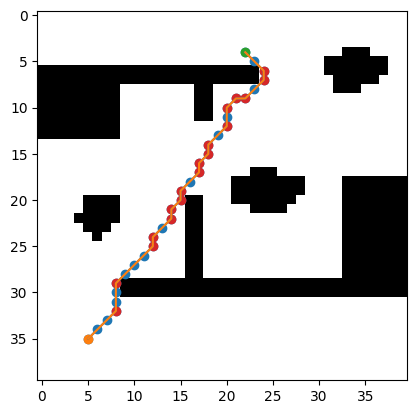

In [28]:
plt.imshow(comp_map, cmap='gray')
plt.plot(crude_path[:, 0], crude_path[:, 1])
plt.scatter(crude_path[:, 0], crude_path[:, 1])
plt.scatter(new_start[0], new_start[1])
plt.scatter(new_end[0], new_end[1])
plt.plot([new_start[0]]+list(core_points[:, 0])+[new_end[0]], [new_start[1]]+list(core_points[:, 1])+[new_end[1]])
plt.scatter(core_points[:, 0], core_points[:, 1])
plt.show()

map5-AStar Planner-1
map5-ABC Optimizer-1
One particle set without change
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10


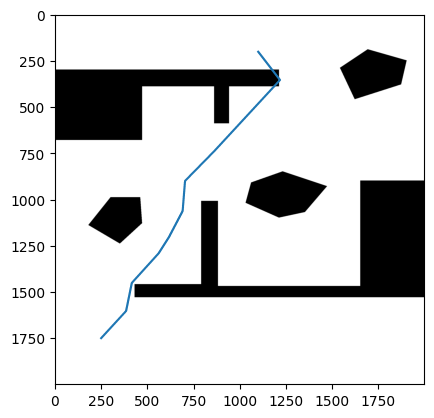

map5-ABC Optimizer-2
One particle set without change
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10


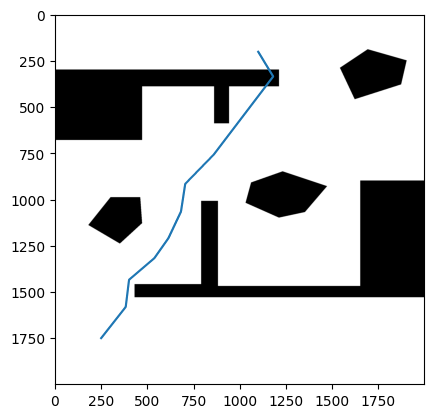

map5-ABC Optimizer-3
One particle set without change
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6


D:\BTP\codes\BTP\Planners\helper.py:114: RuntimeWarning: divide by zero encountered in double_scalars
  com_cost += (com_mass / min_distance)


Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10


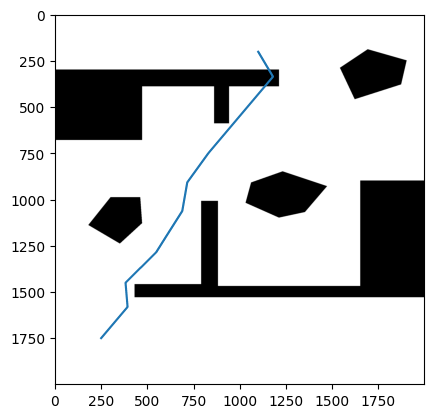

map5-ABC Optimizer-4
One particle set without change
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10


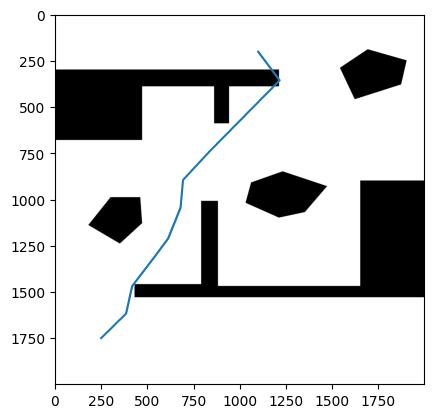

map5-ABC Optimizer-5
One particle set without change
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10


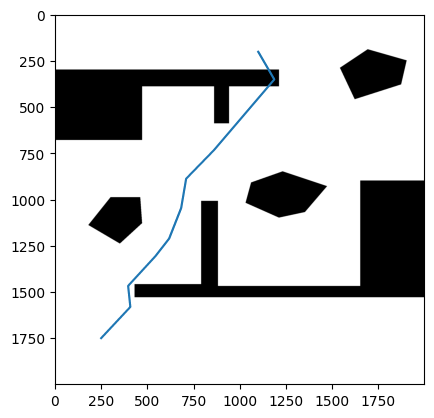

map5-GWO Optimizer-1
One particle set without change
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10


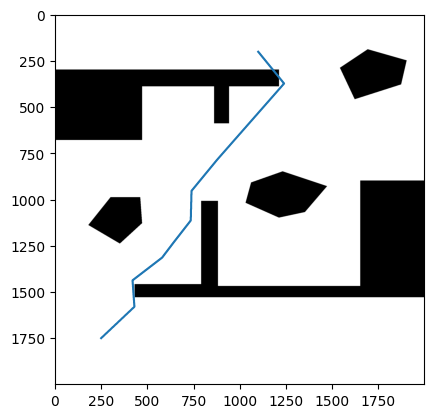

map5-GWO Optimizer-2
One particle set without change
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10


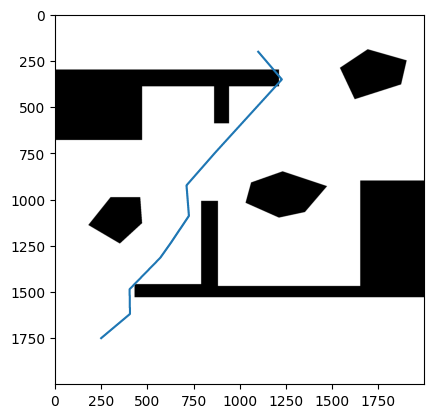

map5-GWO Optimizer-3
One particle set without change
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10


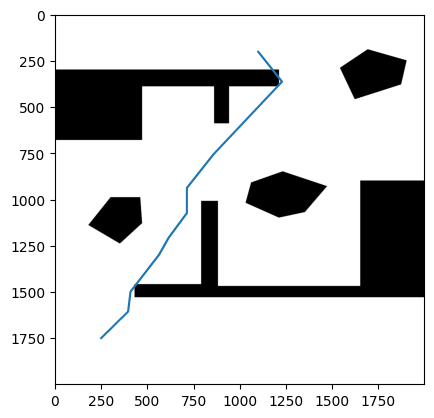

map5-GWO Optimizer-4
One particle set without change
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4


D:\BTP\codes\BTP\Planners\helper.py:114: RuntimeWarning: divide by zero encountered in double_scalars
  com_cost += (com_mass / min_distance)


Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10


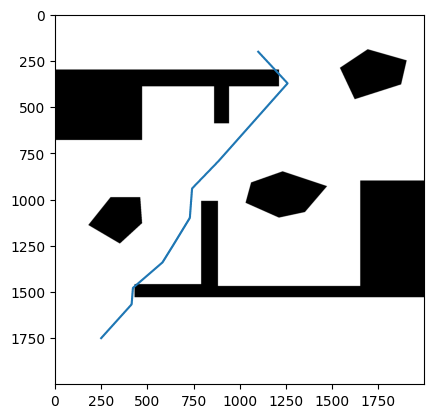

map5-GWO Optimizer-5
One particle set without change
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10


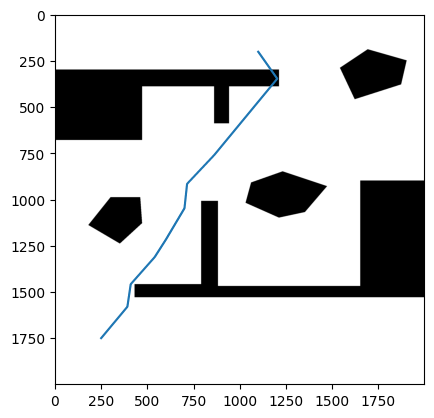

map5-PSO Optimizer-1
One particle set without change
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10


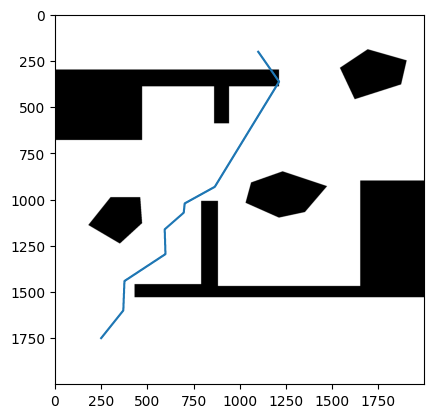

map5-PSO Optimizer-2
One particle set without change
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10


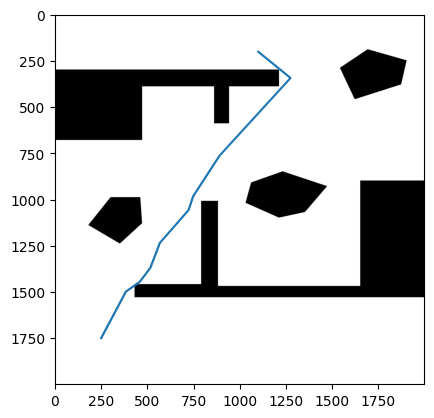

map5-PSO Optimizer-3
One particle set without change
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10


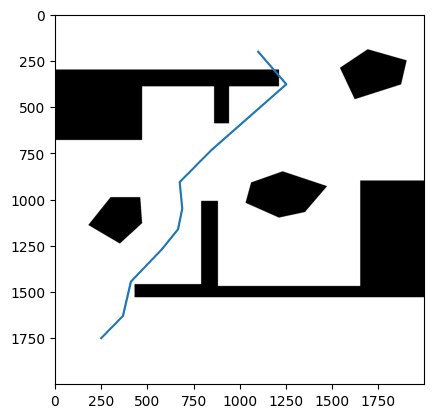

map5-PSO Optimizer-4
One particle set without change
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10


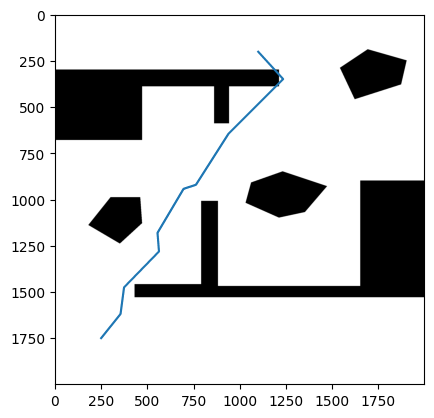

map5-PSO Optimizer-5
One particle set without change
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10


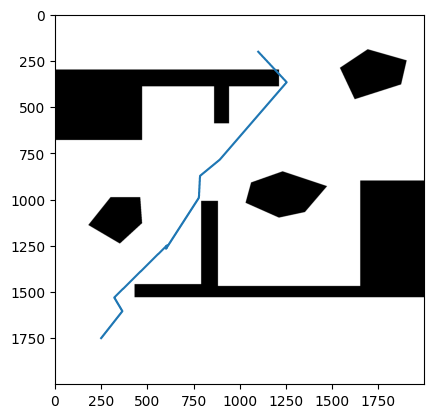

In [26]:
for map_name in map_details.keys():
    curr_details = map_details[map_name]
    
    file_name = curr_details['file_name']
    map_file_name = file_name.split('.')[0]
    map_gen = MapGenerator(os.path.join('map_params', file_name))
    curr_map = map_gen.map.get_map()
    
    start = np.array(curr_details['start']).astype(np.int32)
    end = np.array(curr_details['end']).astype(np.int32)
    
#     com_points, com_weights = get_com_points(curr_map)
#     print("Center of mass points of the current map")
#     plt.imshow(curr_map, cmap='gray')
#     plt.scatter(com_points[:,0], com_points[:,1], s=com_weights/100)
#     plt.show()
#     print('='*20)
    
    crude_particle = points_to_particle(core_points, comp_map.shape)
    
    for planner_name in planner_params.keys():
        curr_params = planner_params[planner_name]
        curr_params['map'] = curr_map
        
        opt_params = curr_params['optimizer_params']
        opt_params['points'] = core_points.shape[0]
        
        opt_params['initial_particle'] = crude_particle
        opt_params['move_range'] = 0.01
        
        for i in range(total_runs):
            run = i + 1
            print(map_name, planner_name, run, sep='-')
            opt_params['iteration_callback'] = warehouse.get_callback(map_file_name, planner_name, run)
            if planner_name == 'AStar Planner':
                break
                planner = AStarPlanner(curr_map)
            else:
                planner = PlannerBase(**curr_params, com_points=com_points, com_weights=com_weights)
            start_time = time.time()
            path = planner.get_path(start, end)
            end_time = time.time()
            elapsed_time = end_time - start_time
            path_length, violations, violation_cost = get_path_cost(curr_map, path)
            results.loc[len(results)] = [map_file_name, planner_name, run, elapsed_time, path_length, violations, violation_cost]
            fig = plt.figure()
            plt.imshow(curr_map, cmap='gray')
            plt.plot(path[:, 0], path[:, 1])
            plt.show()
            if planner_name == 'AStar Planner':
                break

In [26]:
unique_maps = results['map_file'].unique()
unique_planners = results['planner_name'].unique()
for map_name in unique_maps:
    print('Current Map:', map_name)
    save_results = pd.DataFrame({
        'planner_name': pd.Series(dtype='str'),
        'avg_time': pd.Series(dtype='float'),
        'avg_distance': pd.Series(dtype='float'),
        'avg_violation': pd.Series(dtype='float'),
        'avg_violation_cost': pd.Series(dtype='float')
    })
    curr_map_df = results[results['map_file'] == map_name]
    for planner_name in unique_planners:
        curr_df = curr_map_df[curr_map_df['planner_name'] == planner_name]
        avg_time = np.mean(curr_df['time_taken'])
        avg_distance = np.mean(curr_df['distance'])
        avg_violation = np.mean(curr_df['violation'])
        avg_violation_cost  = np.mean(curr_df['violation_cost'])
        save_results.loc[len(save_results)] = [planner_name, avg_time, avg_distance, avg_violation, avg_violation_cost]
    warehouse.save_result(map_name+'.csv', save_results)
    print(save_results)
    print('')

Current Map: custom_map_2_params
    planner_name  avg_time  avg_distance  avg_violation  avg_violation_cost
0  ABC Optimizer  0.709183    620.425540            0.0                 0.0
1  GWO Optimizer  0.439971    616.465742            0.0                 0.0
2  PSO Optimizer  0.417483    603.737820            0.0                 0.0

Current Map: custom_map_4_params
    planner_name  avg_time  avg_distance  avg_violation  avg_violation_cost
0  ABC Optimizer  0.752543    438.743463            1.2                67.6
1  GWO Optimizer  0.504222    619.906954            0.0                 0.0
2  PSO Optimizer  0.475306    566.288874            1.2                 7.6

Current Map: custom_map_3_params
    planner_name  avg_time  avg_distance  avg_violation  avg_violation_cost
0  ABC Optimizer  2.626898    704.098455            0.0                 0.0
1  GWO Optimizer  1.574053    665.231846            0.0                 0.0
2  PSO Optimizer  1.525062    656.180879            0.0        

In [12]:
new_start

array([1, 4])

In [13]:
start

array([100, 400])

In [9]:
q_planner.curr_point

array([-9, -6])